In [2]:
import pandas as pd

# 明确列出每年对应的 CSV 文件路径和年份
file_year_map = {
    2016: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d16_v4.csv',
    2017: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d17_v4.csv',
    2018: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d18_v4.csv',
    2019: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d19_v4.csv',
    2020: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d20_v4.csv',
    2021: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d21_v4.csv',
    2022: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d22_v4.csv',
    2023: 'C:/Users/ZITIAO/Desktop/16-23 dataset/d16-23_v4/d23_v4.csv'
}

pollution_dfs = []

for year, path in file_year_map.items():
    df = pd.read_csv(path)
    df['Year'] = year
    pollution_dfs.append(df)

# 合并所有年份数据
pollution_df = pd.concat(pollution_dfs, ignore_index=True)

# 过滤出排放量高于报告阈值的数据
pollution_filtered = pollution_df[
    pollution_df['QUANTITY RELEASED (kg)'] > pollution_df['REPORTING THRESHOLD (kg)']
].copy()

# 清洗公司名称
pollution_filtered['OPERATOR NAME'] = pollution_filtered['OPERATOR NAME'].str.strip().str.lower()

# 聚合：每公司-每年-每种污染物的排放总量
pollution_grouped = (
    pollution_filtered
    .groupby(['OPERATOR NAME', 'Year', 'SUBSTANCE NAME'], as_index=False)
    .agg({'QUANTITY RELEASED (kg)': 'sum'})
    .rename(columns={'QUANTITY RELEASED (kg)': 'Total Emission (kg)'})
)

# 保存结果（可选）
pollution_grouped.to_csv('C:/Users/ZITIAO/Desktop/filtered_grouped_pollution.csv', index=False)

# 显示前几行
pollution_grouped.head()


,OPERATOR NAME,Year,SUBSTANCE NAME,Total Emission (kg)
0,abaris holdings ltd,2016,Copper,104.00
1,abaris holdings ltd,2017,Copper,41.00
2,abaris holdings ltd,2018,Copper,61.00
3,abaris holdings ltd,2019,Copper,97.00
4,anglian water,2016,Benzo(a)pyrene,1.15


In [4]:
import pandas as pd

# 读取原始公司数据
df = pd.read_csv('C:/Users/ZITIAO/Desktop/16-23 dataset/All_Companies_Data_16-23.csv')

# 统一公司名格式，方便匹配
df['OPERATOR NAME'] = df['OPERATOR NAME'].str.strip().str.lower()

# 年份范围
years = list(range(2016, 2024))  # 包含 2016–2023 共 8 年

# 创建一个空列表存放转换结果
long_df_list = []

for year in years:
    temp_df = df[['OPERATOR NAME']].copy()
    temp_df['Year'] = year
    temp_df['Employee'] = df[f'Employee {year}']
    temp_df['Turnover'] = df[f'Turnover {year}']
    long_df_list.append(temp_df)

# 合并所有年度数据
company_long_df = pd.concat(long_df_list, ignore_index=True)

# 删除员工数和营业额都是空的行（通常是无数据）
company_long_df = company_long_df.dropna(subset=['Employee', 'Turnover'], how='all')

# 添加新的列：Turnover（百万）
company_long_df['Turnover_million'] = company_long_df['Turnover'] / 1e6

# 保存为 CSV 文件
company_long_df.to_csv('C:/Users/ZITIAO/Desktop/company_long_format.csv', index=False)

# 可选：查看前几行
print(company_long_df.head())


                           OPERATOR NAME  Year  Employee      Turnover  \
0                       3c waste limited  2016      64.0  6.925900e+07   
1                          anglian water  2016    4432.0  1.185000e+09   
2               biffa waste services ltd  2016    4336.0  6.585000e+08   
3  bradley park waste management limited  2016      21.0           NaN   
4                     brisitsh sugar plc  2016    1834.0  5.854000e+08   

   Turnover_million  
0            69.259  
1          1185.000  
2           658.500  
3               NaN  
4           585.400  


In [23]:
import pandas as pd

# 读取公司长格式数据
company_df = pd.read_csv('C:/Users/ZITIAO/Desktop/company_long_format.csv')

# 读取污染排放数据
pollution_df = pd.read_csv('C:/Users/ZITIAO/Desktop/filtered_grouped_pollution.csv')

# 清洗公司名称统一格式（如果还未清洗）
company_df['OPERATOR NAME'] = company_df['OPERATOR NAME'].str.strip().str.lower()
pollution_df['OPERATOR NAME'] = pollution_df['OPERATOR NAME'].str.strip().str.lower()

# 合并数据：按公司名和年份
merged_df = pd.merge(
    pollution_df, company_df,
    on=['OPERATOR NAME', 'Year'],
    how='inner'  # 只保留两者都存在的数据
)

# 保存合并后的数据
merged_df.to_csv('C:/Users/ZITIAO/Desktop/merged_for_regression.csv', index=False)

# 可选：预览前几行
print(merged_df.head())


   OPERATOR NAME  Year          SUBSTANCE NAME  Total Emission (kg)  Employee  \
0  anglian water  2016          Benzo(a)pyrene                 1.15    4432.0   
1  anglian water  2016                  Copper              1672.40    4432.0   
2  anglian water  2016            Fluoranthene                 1.59    4432.0   
3  anglian water  2016  Indeno(1,2,3-cd)pyrene                 6.08    4432.0   
4  anglian water  2017                  Copper              1295.60    4462.0   

       Turnover  Turnover_million  
0  1.185000e+09            1185.0  
1  1.185000e+09            1185.0  
2  1.185000e+09            1185.0  
3  1.185000e+09            1185.0  
4  1.227000e+09            1227.0  


In [6]:
import pandas as pd
import re

# 自定义函数：仅移除末尾的括号内容（公司现名称）
def remove_trailing_parentheses(name):
    if pd.isna(name):
        return None
    # 匹配以空格+括号结尾的情况
    return re.sub(r'\s*\([^)]*\)$', '', name).strip().lower()

# 应用于公司数据（OPERATOR NAME 字段）
company_df = pd.read_csv('C:/Users/ZITIAO/Desktop/company_long_format.csv')
company_df['Company_Clean'] = company_df['OPERATOR NAME'].apply(remove_trailing_parentheses)

# 同样应用于污染数据
pollution_df = pd.read_csv('C:/Users/ZITIAO/Desktop/filtered_grouped_pollution.csv')
pollution_df['Company_Clean'] = pollution_df['OPERATOR NAME'].str.strip().str.lower()

# 然后你可以使用 Company_Clean 和 Year 合并：
merged_df = pd.merge(
    pollution_df,
    company_df,
    on=['Company_Clean', 'Year'],
    how='inner'
)

# 保存合并结果（可选）
merged_df.to_csv('C:/Users/ZITIAO/Desktop/merged_cleaned.csv', index=False)

# 查看部分结果
print(merged_df[['Company_Clean', 'Year', 'SUBSTANCE NAME', 'Total Emission (kg)', 'Employee', 'Turnover', 'Turnover_million']].head())


   Company_Clean  Year          SUBSTANCE NAME  Total Emission (kg)  Employee  \
0  anglian water  2016          Benzo(a)pyrene                 1.15    4432.0   
1  anglian water  2016                  Copper              1672.40    4432.0   
2  anglian water  2016            Fluoranthene                 1.59    4432.0   
3  anglian water  2016  Indeno(1,2,3-cd)pyrene                 6.08    4432.0   
4  anglian water  2017                  Copper              1295.60    4462.0   

       Turnover  Turnover_million  
0  1.185000e+09            1185.0  
1  1.185000e+09            1185.0  
2  1.185000e+09            1185.0  
3  1.185000e+09            1185.0  
4  1.227000e+09            1227.0  


**log_emission ~ log_turnover**

Regression Analyse Results: Benzo(a)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     23.35
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           8.39e-06
Time:                        18:17:40   Log-Likelihood:                -93.431
No. Observations:                  68   AIC:                             190.9
Df Residuals:                      66   BIC:                             195.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const

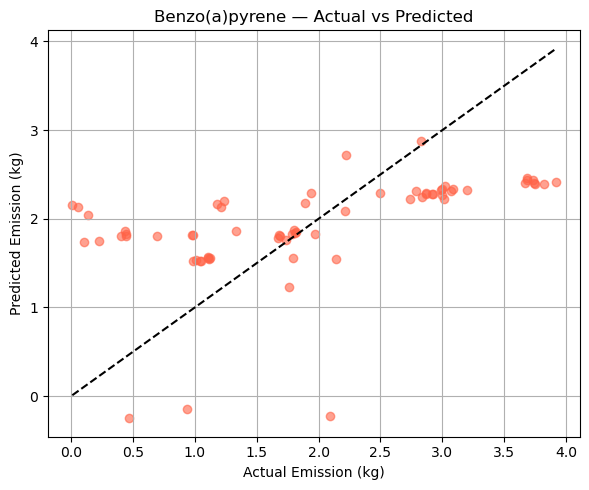

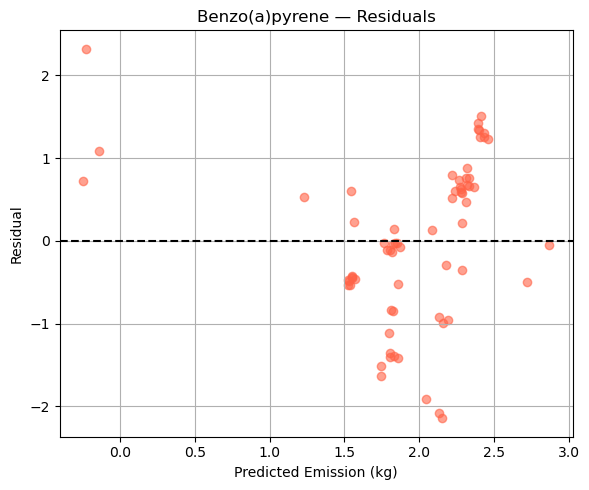

Regression Analyse Results: Copper
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     39.61
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           5.83e-09
Time:                        18:17:41   Log-Likelihood:                -225.55
No. Observations:                 117   AIC:                             455.1
Df Residuals:                     115   BIC:                             460.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        

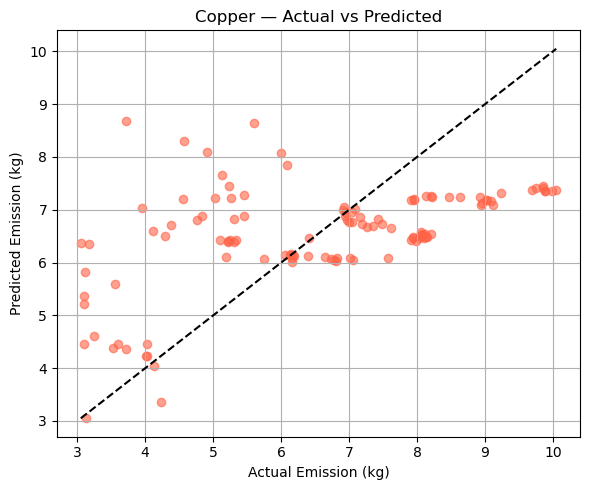

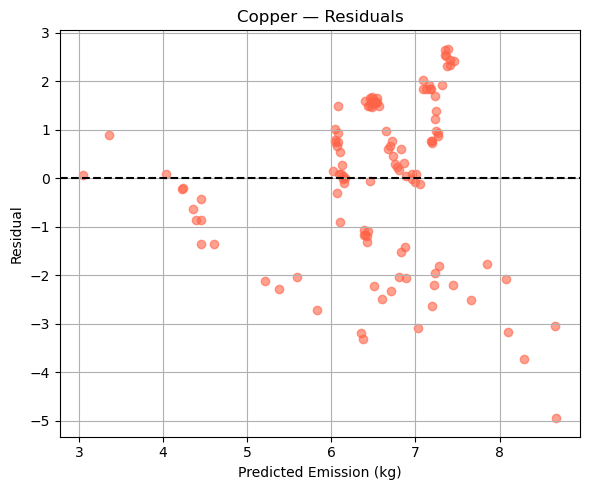

Regression Analyse Results: Fluoranthene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     12.48
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           0.000655
Time:                        18:17:41   Log-Likelihood:                -147.64
No. Observations:                  91   AIC:                             299.3
Df Residuals:                      89   BIC:                             304.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

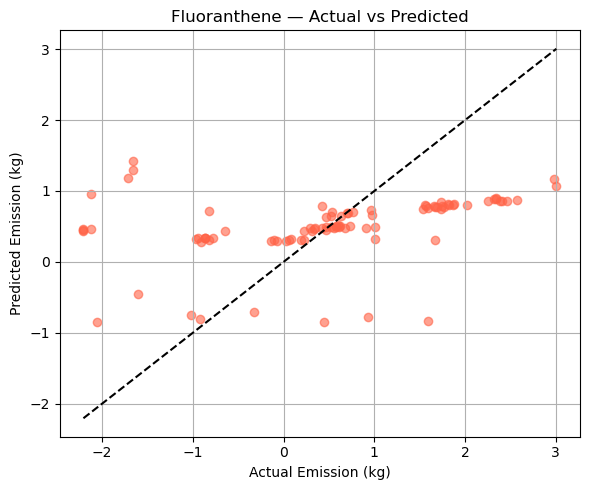

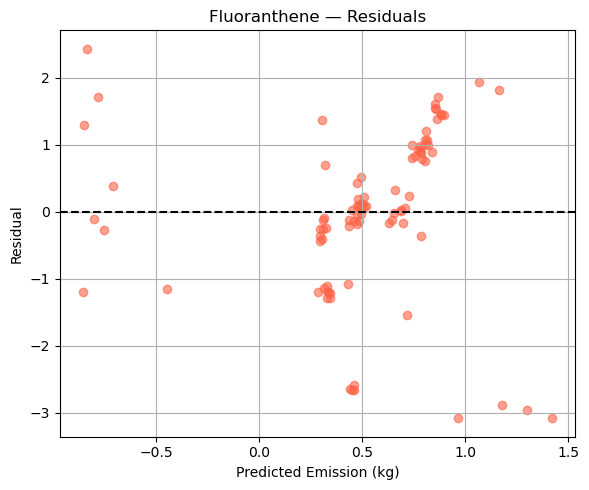

Regression Analyse Results: Indeno(1,2,3-cd)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     55.40
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           3.09e-10
Time:                        18:17:41   Log-Likelihood:                -73.281
No. Observations:                  66   AIC:                             150.6
Df Residuals:                      64   BIC:                             154.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

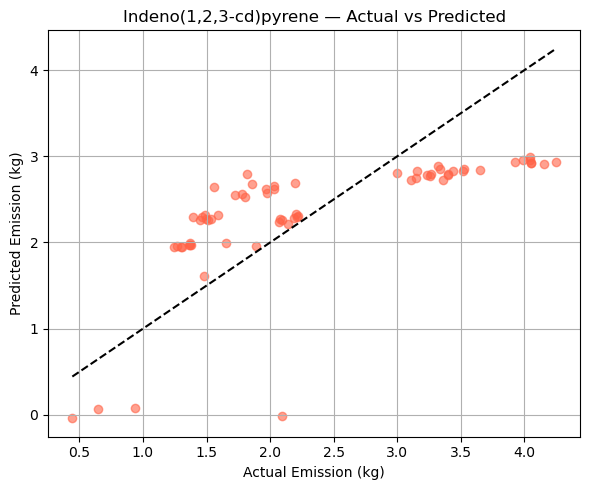

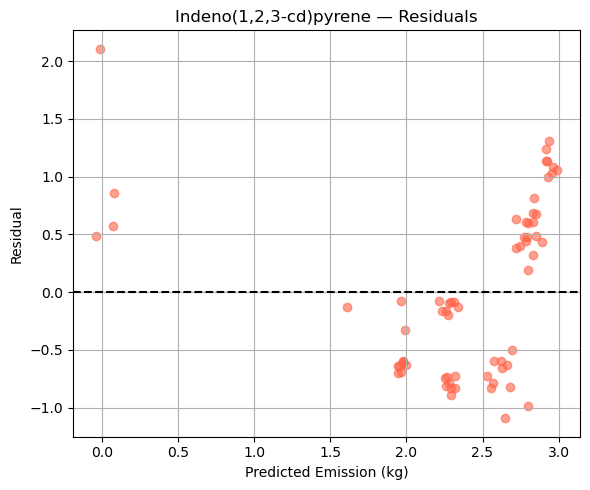

Regression Analyse Results: Cypermethrin
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     14.08
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           0.000413
Time:                        18:17:41   Log-Likelihood:                -131.08
No. Observations:                  59   AIC:                             266.2
Df Residuals:                      57   BIC:                             270.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

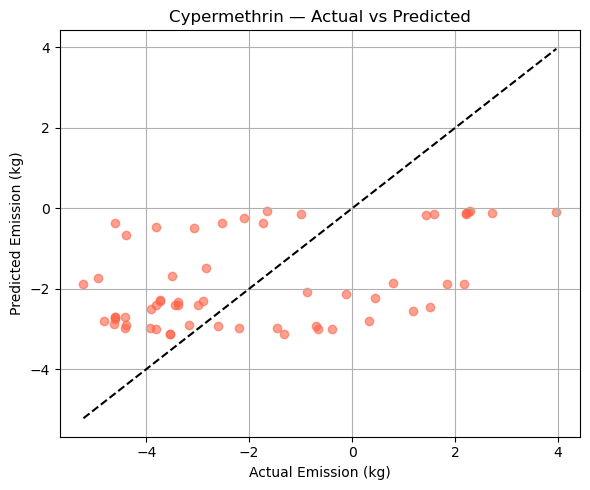

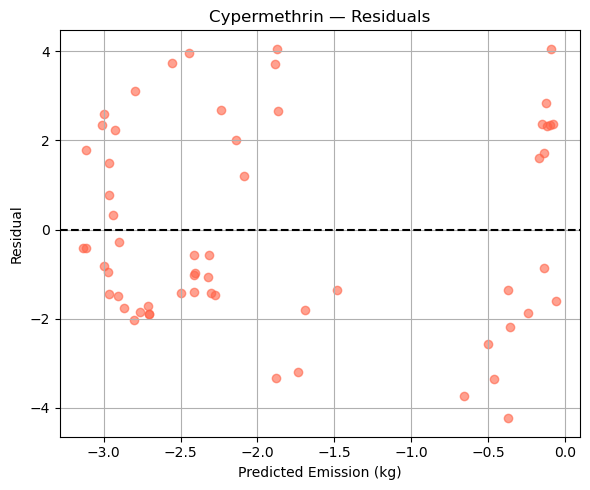

In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

# 为图片保存设置文件夹（可选）
# output_dir = 'regression_plots'
# os.makedirs(output_dir, exist_ok=True)

# 获取所有污染物名称
pollutants = merged_df['SUBSTANCE NAME'].dropna().unique()

# 开始循环每个污染物
for pollutant in pollutants:
    print("=" * 100)
    print(f"Regression Analyse Results: {pollutant}")
    print("=" * 100)

    # 筛选对应污染物，且 Turnover 必须大于0
    df_sub = merged_df[
        (merged_df['SUBSTANCE NAME'].str.lower() == pollutant.lower()) &
        (merged_df['Turnover_million'] > 0) &
        (merged_df['Employee'] > 0) &
        (merged_df['Total Emission (kg)'] > 0)
    ].copy()

    # 如果样本太少，跳过该污染物
    if df_sub.shape[0] < 10:
        print(f"样本太少，跳过：{pollutant}")
        continue

    df_sub['log_emission'] = np.log(df_sub['Total Emission (kg)'])
    df_sub['log_employee'] = np.log(df_sub['Employee'])
    df_sub['log_turnover'] = np.log(df_sub['Turnover_million'])

    # 去除 inf/nan
    df_sub = df_sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_turnover', 'log_employee', 'log_emission'])

    # 再次确认样本是否足够
    if df_sub.shape[0] < 10:
        print(f"有效样本不足，跳过：{pollutant}")
        continue

    # 设置自变量与因变量
    X = df_sub[['log_turnover']]
    X = sm.add_constant(X)
    y = df_sub['log_emission']

    # 拟合模型
    model = sm.OLS(y, X).fit()

    # 打印回归结果
    print(model.summary())

    # 生成预测与残差
    y_pred = model.predict(X)
    residuals = y - y_pred

    # 画图1：实际 vs 预测
    plt.figure(figsize=(6, 5))
    plt.scatter(y, y_pred, alpha=0.6, color='tomato')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.xlabel("Actual Emission (kg)")
    plt.ylabel("Predicted Emission (kg)")
    plt.title(f"{pollutant} — Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # 画图2：残差图
    plt.figure(figsize=(6, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, color='tomato')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Predicted Emission (kg)")
    plt.ylabel("Residual")
    plt.title(f"{pollutant} — Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



**log_emission ~ log_employee**

Regression Analyse Results: Benzo(a)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     21.73
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           1.58e-05
Time:                        18:18:27   Log-Likelihood:                -94.055
No. Observations:                  68   AIC:                             192.1
Df Residuals:                      66   BIC:                             196.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const

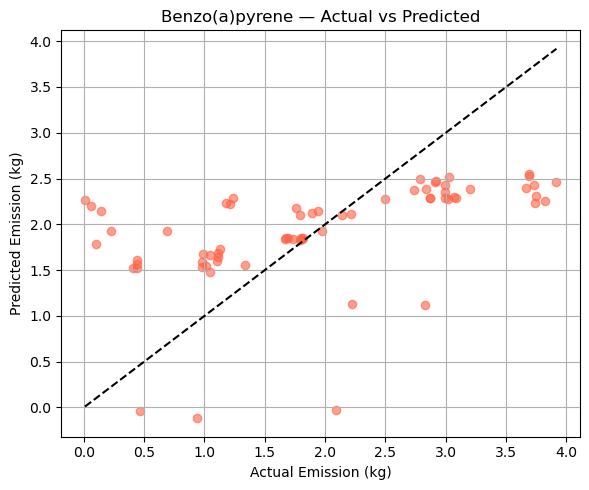

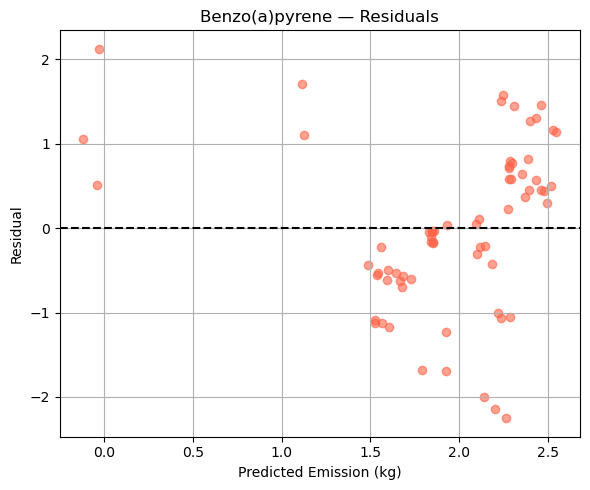

Regression Analyse Results: Copper
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     66.92
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           4.25e-13
Time:                        18:18:28   Log-Likelihood:                -216.03
No. Observations:                 117   AIC:                             436.1
Df Residuals:                     115   BIC:                             441.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        

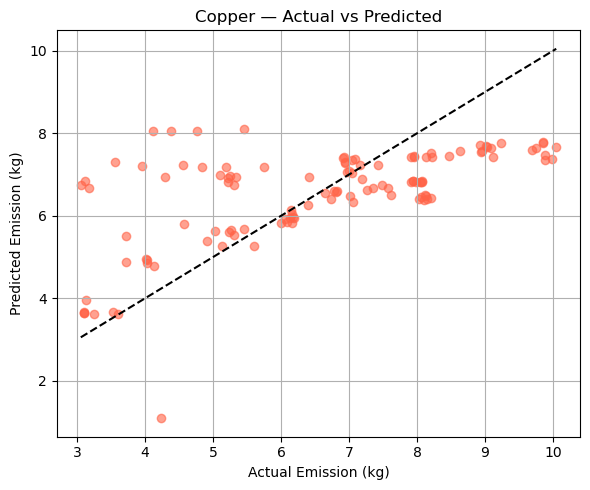

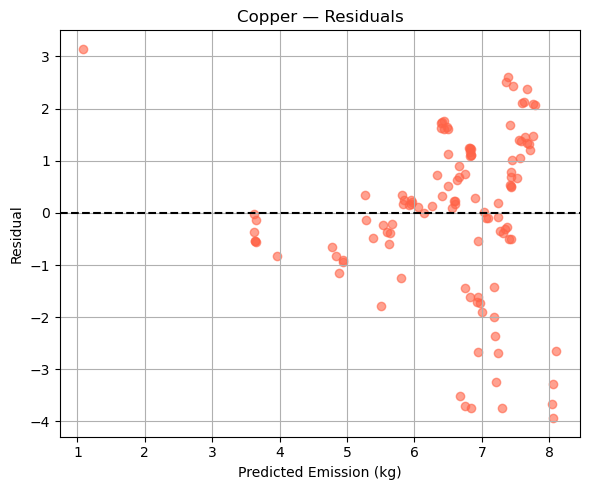

Regression Analyse Results: Fluoranthene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     34.03
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           8.61e-08
Time:                        18:18:28   Log-Likelihood:                -138.87
No. Observations:                  91   AIC:                             281.7
Df Residuals:                      89   BIC:                             286.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

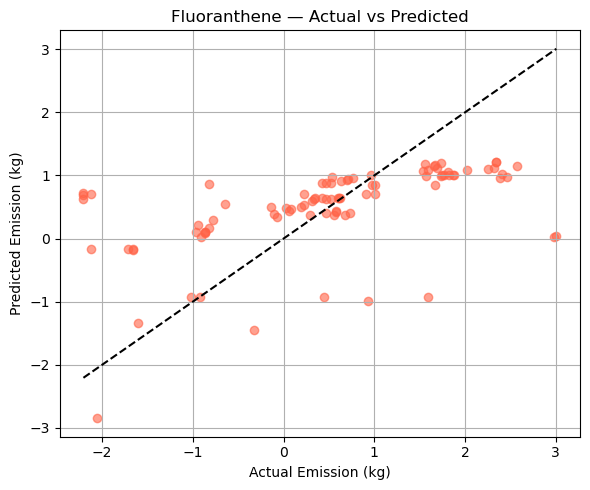

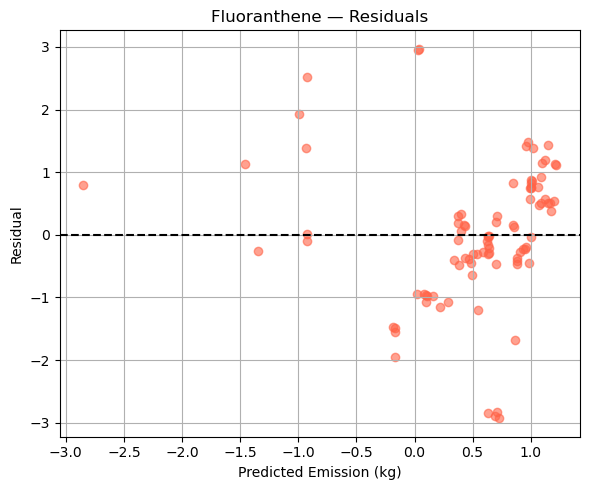

Regression Analyse Results: Indeno(1,2,3-cd)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     51.99
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           7.94e-10
Time:                        18:18:28   Log-Likelihood:                -74.238
No. Observations:                  66   AIC:                             152.5
Df Residuals:                      64   BIC:                             156.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

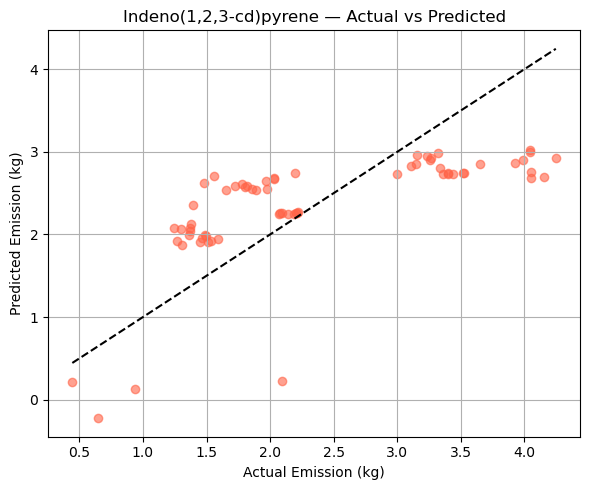

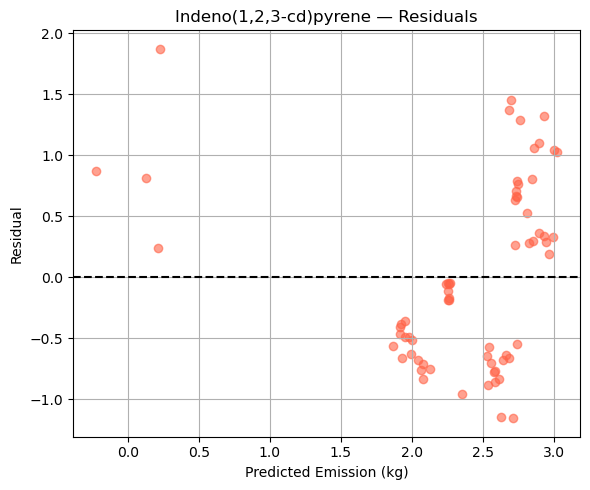

Regression Analyse Results: Cypermethrin
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     3.653
Date:                Mon, 04 Aug 2025   Prob (F-statistic):             0.0610
Time:                        18:18:29   Log-Likelihood:                -135.76
No. Observations:                  59   AIC:                             275.5
Df Residuals:                      57   BIC:                             279.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

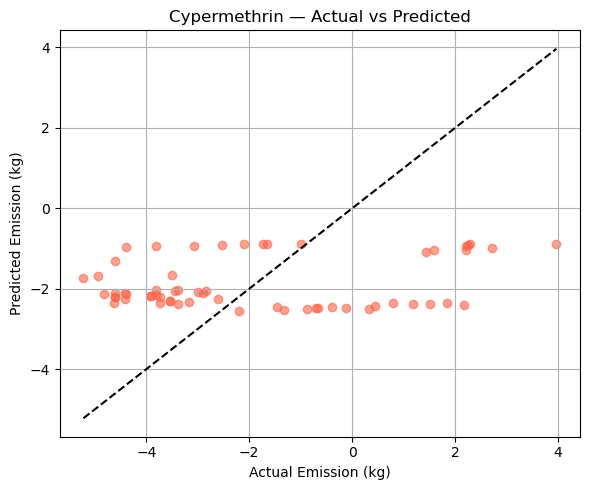

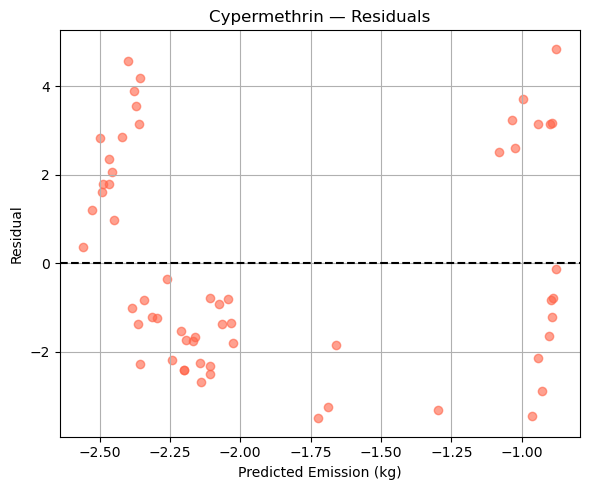

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

# 为图片保存设置文件夹（可选）
# output_dir = 'regression_plots'
# os.makedirs(output_dir, exist_ok=True)

# 获取所有污染物名称
pollutants = merged_df['SUBSTANCE NAME'].dropna().unique()

# 开始循环每个污染物
for pollutant in pollutants:
    print("=" * 100)
    print(f"Regression Analyse Results: {pollutant}")
    print("=" * 100)

    # 筛选对应污染物，且 Turnover 必须大于0
    df_sub = merged_df[
        (merged_df['SUBSTANCE NAME'].str.lower() == pollutant.lower()) &
        (merged_df['Turnover_million'] > 0) &
        (merged_df['Employee'] > 0) &
        (merged_df['Total Emission (kg)'] > 0)
    ].copy()

    # 如果样本太少，跳过该污染物
    if df_sub.shape[0] < 10:
        print(f"样本太少，跳过：{pollutant}")
        continue

    df_sub['log_emission'] = np.log(df_sub['Total Emission (kg)'])
    df_sub['log_employee'] = np.log(df_sub['Employee'])
    df_sub['log_turnover'] = np.log(df_sub['Turnover_million'])

    # 去除 inf/nan
    df_sub = df_sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_turnover', 'log_employee', 'log_emission'])

    # 再次确认样本是否足够
    if df_sub.shape[0] < 10:
        print(f"有效样本不足，跳过：{pollutant}")
        continue

    # 设置自变量与因变量
    X = df_sub[['log_employee']]
    X = sm.add_constant(X)
    y = df_sub['log_emission']

    # 拟合模型
    model = sm.OLS(y, X).fit()

    # 打印回归结果
    print(model.summary())

    # 生成预测与残差
    y_pred = model.predict(X)
    residuals = y - y_pred

    # 画图1：实际 vs 预测
    plt.figure(figsize=(6, 5))
    plt.scatter(y, y_pred, alpha=0.6, color='tomato')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.xlabel("Actual Emission (kg)")
    plt.ylabel("Predicted Emission (kg)")
    plt.title(f"{pollutant} — Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # 画图2：残差图
    plt.figure(figsize=(6, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, color='tomato')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Predicted Emission (kg)")
    plt.ylabel("Residual")
    plt.title(f"{pollutant} — Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



**log_emission ~ Year**

回归分析结果: Benzo(a)pyrene
                             OLS Regression Results                            
Dep. Variable:     Total Emission (kg)   R-squared:                       0.004
Model:                             OLS   Adj. R-squared:                 -0.011
Method:                  Least Squares   F-statistic:                    0.2915
Date:                 Thu, 31 Jul 2025   Prob (F-statistic):              0.591
Time:                         20:20:42   Log-Likelihood:                -270.72
No. Observations:                   68   AIC:                             545.4
Df Residuals:                       66   BIC:                             549.9
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -750.14

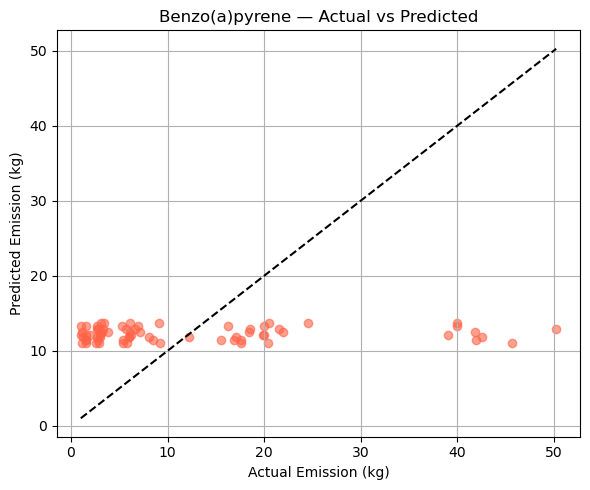

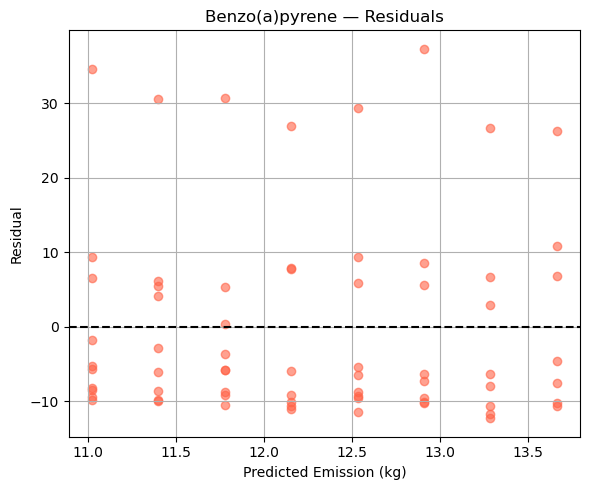

回归分析结果: Copper
                             OLS Regression Results                            
Dep. Variable:     Total Emission (kg)   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.008
Method:                  Least Squares   F-statistic:                   0.03534
Date:                 Thu, 31 Jul 2025   Prob (F-statistic):              0.851
Time:                         20:20:42   Log-Likelihood:                -1163.2
No. Observations:                  117   AIC:                             2330.
Df Residuals:                      115   BIC:                             2336.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.621e+04   4.2

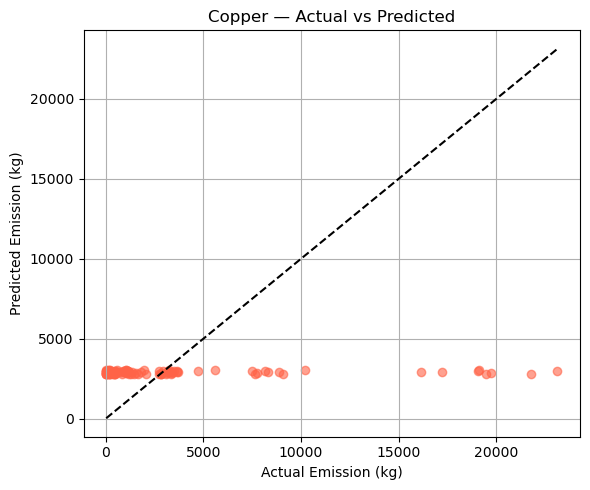

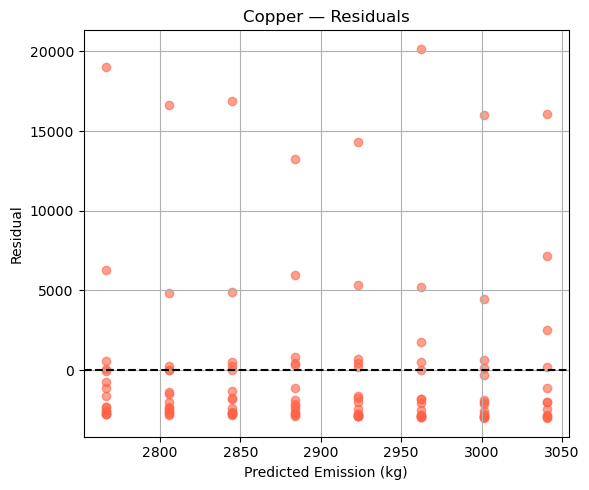

回归分析结果: Fluoranthene
                             OLS Regression Results                            
Dep. Variable:     Total Emission (kg)   R-squared:                       0.024
Model:                             OLS   Adj. R-squared:                  0.013
Method:                  Least Squares   F-statistic:                     2.199
Date:                 Thu, 31 Jul 2025   Prob (F-statistic):              0.142
Time:                         20:20:43   Log-Likelihood:                -254.03
No. Observations:                   91   AIC:                             512.1
Df Residuals:                       89   BIC:                             517.1
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        567.3488

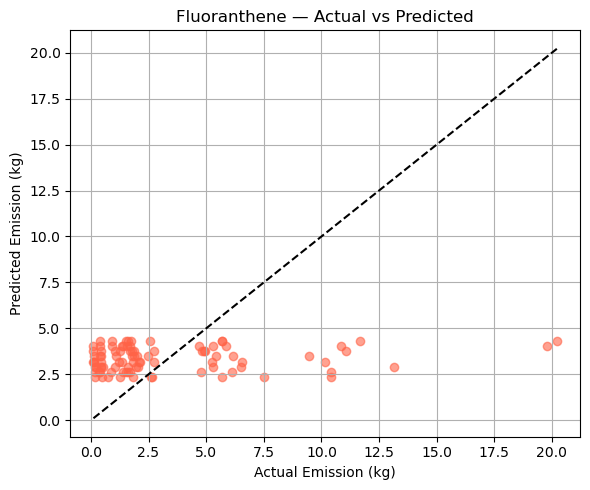

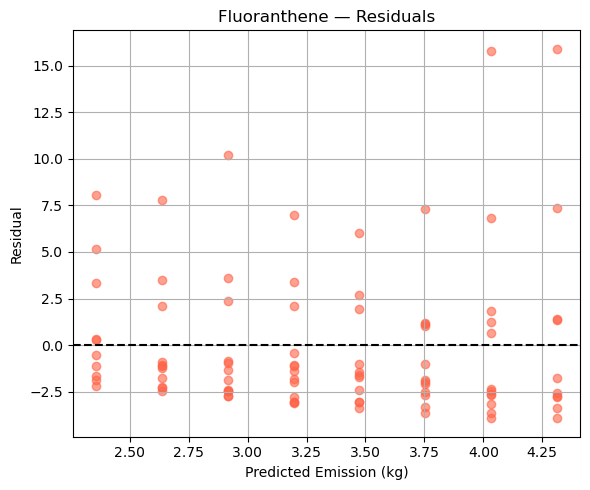

回归分析结果: Indeno(1,2,3-cd)pyrene
                             OLS Regression Results                            
Dep. Variable:     Total Emission (kg)   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                 -0.012
Method:                  Least Squares   F-statistic:                    0.2160
Date:                 Thu, 31 Jul 2025   Prob (F-statistic):              0.644
Time:                         20:20:43   Log-Likelihood:                -284.93
No. Observations:                   66   AIC:                             573.9
Df Residuals:                       64   BIC:                             578.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

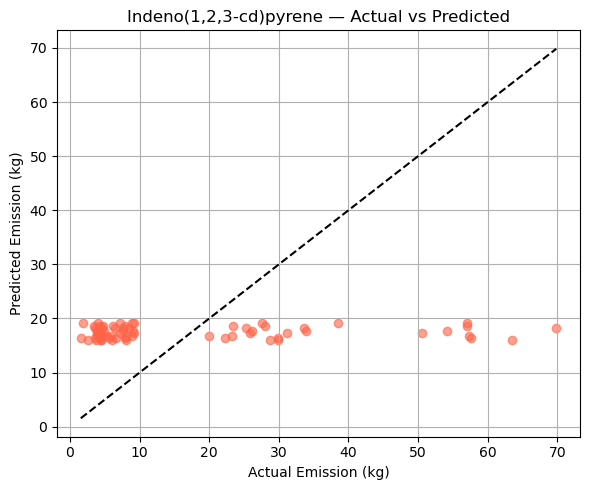

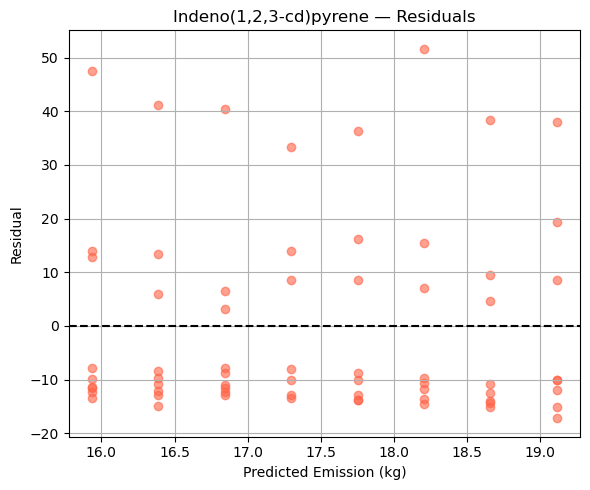

回归分析结果: Cypermethrin
                             OLS Regression Results                            
Dep. Variable:     Total Emission (kg)   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                 -0.015
Method:                  Least Squares   F-statistic:                    0.1190
Date:                 Thu, 31 Jul 2025   Prob (F-statistic):              0.731
Time:                         20:20:44   Log-Likelihood:                -201.52
No. Observations:                   59   AIC:                             407.0
Df Residuals:                       57   BIC:                             411.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -297.0858

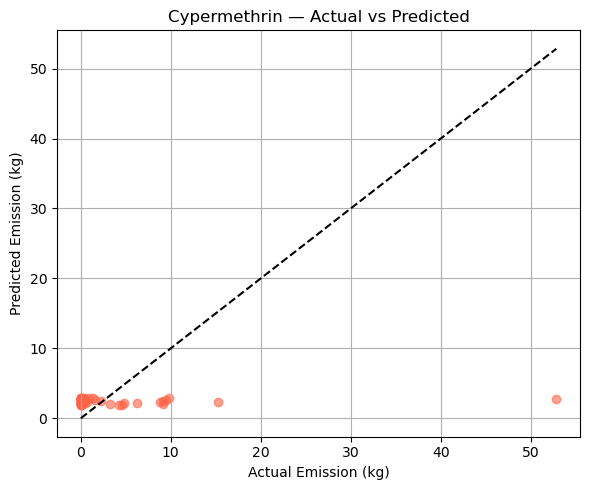

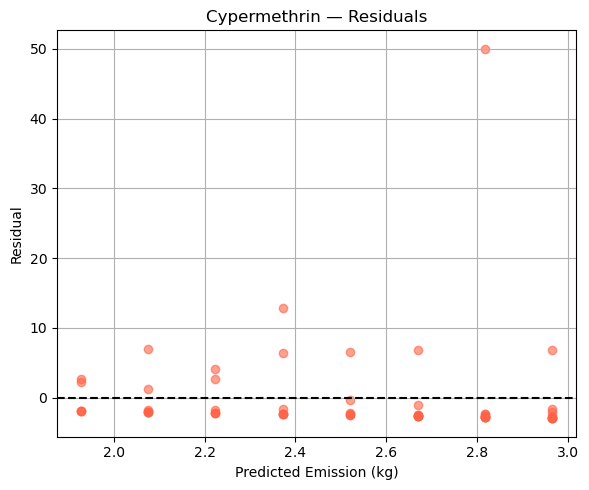

In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

# 为图片保存设置文件夹（可选）
# output_dir = 'regression_plots'
# os.makedirs(output_dir, exist_ok=True)

# 获取所有污染物名称
pollutants = merged_df['SUBSTANCE NAME'].dropna().unique()

# 开始循环每个污染物
for pollutant in pollutants:
    print("=" * 100)
    print(f"回归分析结果: {pollutant}")
    print("=" * 100)

    # 筛选对应污染物，且 Turnover 必须大于0
    df_sub = merged_df[
        (merged_df['SUBSTANCE NAME'].str.lower() == pollutant.lower()) &
        (merged_df['Year'] > 0)
    ].copy()

    # 如果样本太少，跳过该污染物
    if df_sub.shape[0] < 10:
        print(f"样本太少，跳过：{pollutant}")
        continue

    # 对 Turnover 取对数
    df_sub['log_turnover'] = np.log(df_sub['Turnover_million'])

    # 去除 inf/nan
    df_sub = df_sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_turnover', 'Employee', 'Total Emission (kg)'])

    # 再次确认样本是否足够
    if df_sub.shape[0] < 10:
        print(f"有效样本不足，跳过：{pollutant}")
        continue

    # 设置自变量与因变量
    X = df_sub[['Year']]
    X = sm.add_constant(X)
    y = df_sub['Total Emission (kg)']

    # 拟合模型
    model = sm.OLS(y, X).fit()

    # 打印回归结果
    print(model.summary())

    # 生成预测与残差
    y_pred = model.predict(X)
    residuals = y - y_pred

    # 画图1：实际 vs 预测
    plt.figure(figsize=(6, 5))
    plt.scatter(y, y_pred, alpha=0.6, color='tomato')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.xlabel("Actual Emission (kg)")
    plt.ylabel("Predicted Emission (kg)")
    plt.title(f"{pollutant} — Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{pollutant}_actual_vs_pred.png")
    plt.show()


    # 画图2：残差图
    plt.figure(figsize=(6, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, color='tomato')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Predicted Emission (kg)")
    plt.ylabel("Residual")
    plt.title(f"{pollutant} — Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{pollutant}_residuals.png")
    plt.show()



**log_emission ~ log_turnover + log_employee**

Regression Analyse Results: Benzo(a)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     12.77
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           2.10e-05
Time:                        18:33:52   Log-Likelihood:                -92.461
No. Observations:                  68   AIC:                             190.9
Df Residuals:                      65   BIC:                             197.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const

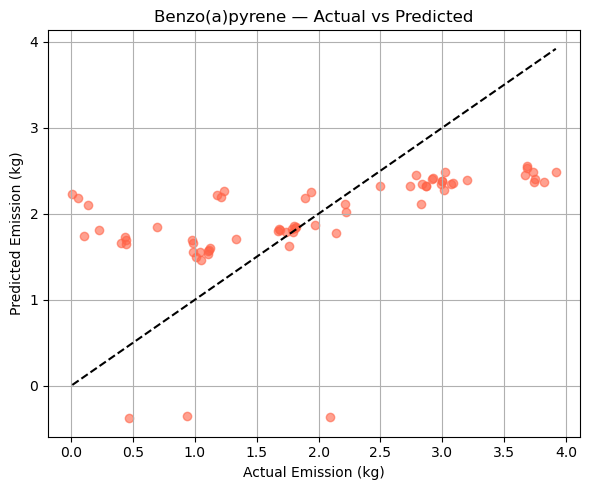

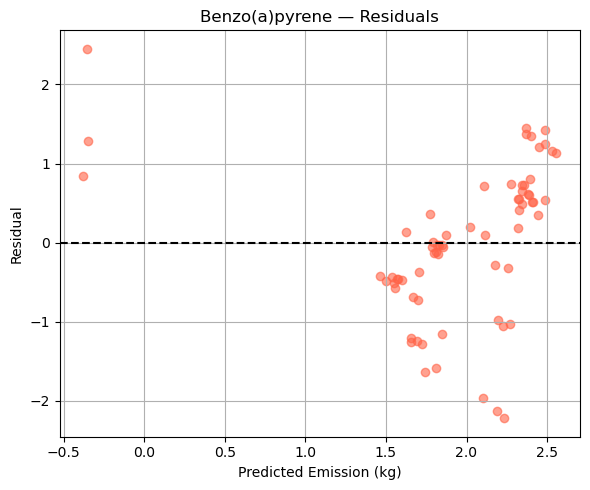

Regression Analyse Results: Copper
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     36.74
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           4.85e-13
Time:                        18:33:53   Log-Likelihood:                -213.77
No. Observations:                 117   AIC:                             433.5
Df Residuals:                     114   BIC:                             441.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        

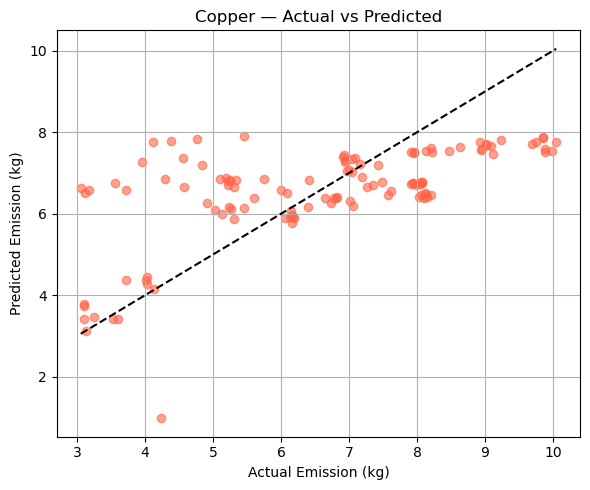

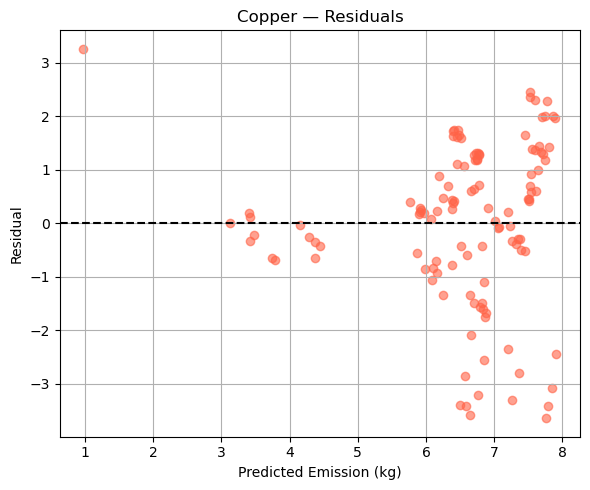

Regression Analyse Results: Fluoranthene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     17.09
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           5.35e-07
Time:                        18:33:53   Log-Likelihood:                -138.68
No. Observations:                  91   AIC:                             283.4
Df Residuals:                      88   BIC:                             290.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

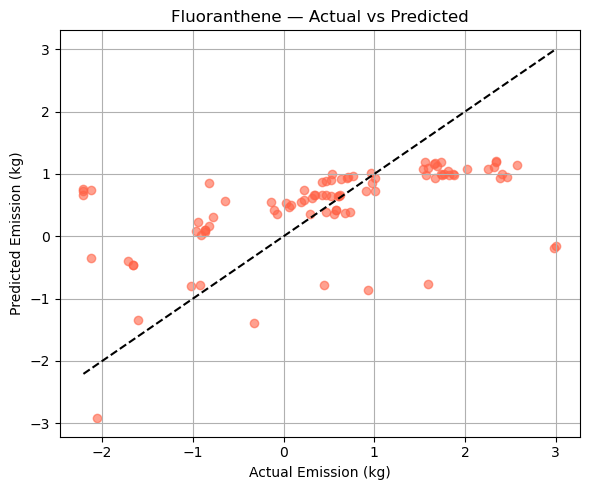

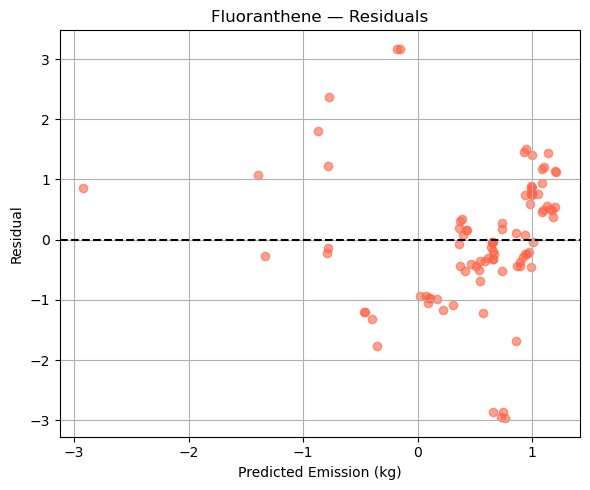

Regression Analyse Results: Indeno(1,2,3-cd)pyrene
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     27.87
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           2.14e-09
Time:                        18:33:53   Log-Likelihood:                -72.945
No. Observations:                  66   AIC:                             151.9
Df Residuals:                      63   BIC:                             158.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

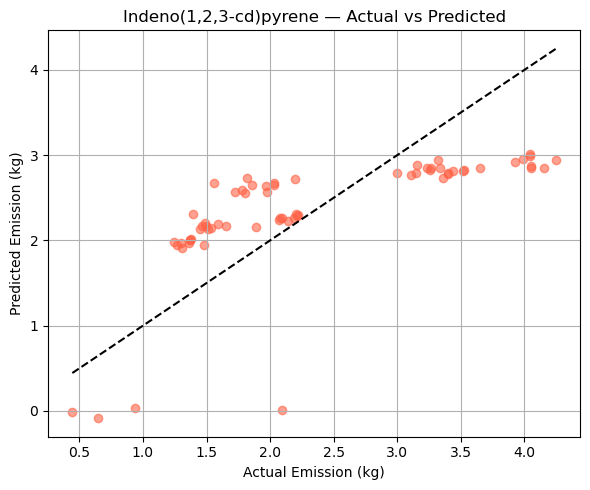

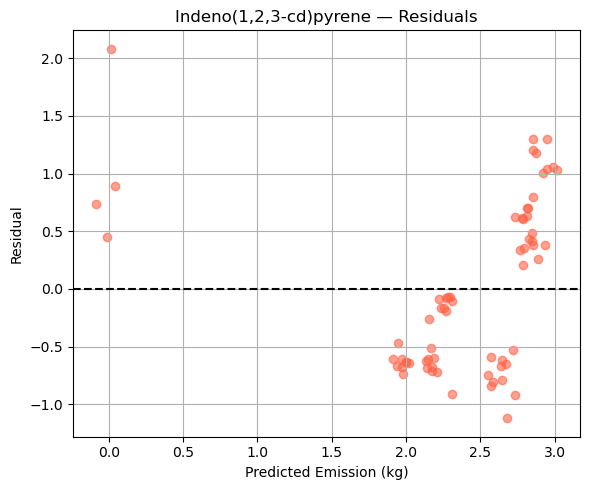

Regression Analyse Results: Cypermethrin
                            OLS Regression Results                            
Dep. Variable:           log_emission   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     21.46
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           1.21e-07
Time:                        18:33:53   Log-Likelihood:                -120.81
No. Observations:                  59   AIC:                             247.6
Df Residuals:                      56   BIC:                             253.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

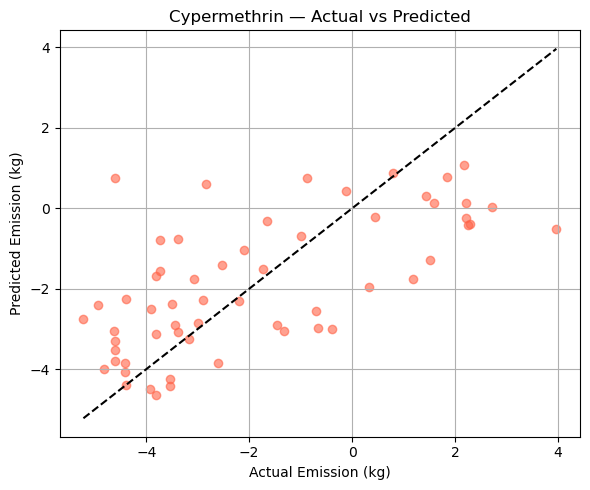

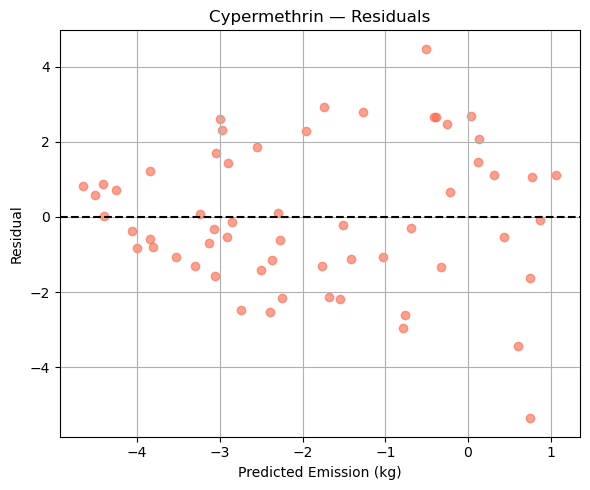

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

# 为图片保存设置文件夹（可选）
# output_dir = 'regression_plots'
# os.makedirs(output_dir, exist_ok=True)

# 获取所有污染物名称
pollutants = merged_df['SUBSTANCE NAME'].dropna().unique()

# 开始循环每个污染物
for pollutant in pollutants:
    print("=" * 100)
    print(f"Regression Analyse Results: {pollutant}")
    print("=" * 100)

    # 筛选对应污染物，且 Turnover 必须大于0
    df_sub = merged_df[
        (merged_df['SUBSTANCE NAME'].str.lower() == pollutant.lower()) &
        (merged_df['Turnover_million'] > 0) &
        (merged_df['Employee'] > 0) &
        (merged_df['Total Emission (kg)'] > 0)
    ].copy()

    # 如果样本太少，跳过该污染物
    if df_sub.shape[0] < 10:
        print(f"样本太少，跳过：{pollutant}")
        continue

    df_sub['log_emission'] = np.log(df_sub['Total Emission (kg)'])
    df_sub['log_employee'] = np.log(df_sub['Employee'])
    df_sub['log_turnover'] = np.log(df_sub['Turnover_million'])

    # 去除 inf/nan
    df_sub = df_sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_turnover', 'log_employee', 'log_emission'])

    # 再次确认样本是否足够
    if df_sub.shape[0] < 10:
        print(f"有效样本不足，跳过：{pollutant}")
        continue

    # 设置自变量与因变量
    X = df_sub[['log_turnover', 'log_employee']]
    X = sm.add_constant(X)
    y = df_sub['log_emission']

    # 拟合模型
    model = sm.OLS(y, X).fit()

    # 打印回归结果
    print(model.summary())

    # 生成预测与残差
    y_pred = model.predict(X)
    residuals = y - y_pred

    # 画图1：实际 vs 预测
    plt.figure(figsize=(6, 5))
    plt.scatter(y, y_pred, alpha=0.6, color='tomato')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.xlabel("Actual Emission (kg)")
    plt.ylabel("Predicted Emission (kg)")
    plt.title(f"{pollutant} — Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # 画图2：残差图
    plt.figure(figsize=(6, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, color='tomato')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Predicted Emission (kg)")
    plt.ylabel("Residual")
    plt.title(f"{pollutant} — Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)


        feature        VIF
0         const  27.208555
1  log_turnover   8.055188
2  log_employee   8.055188
